# Tutorial1: Compute Metric Tensor for Generator and Explore the Axes
This basically correspond to Figure 1 and our method.

## Compute Hessian / Metric Tensor on Image Manifold
First load the package and the GAN loaders and wrappers.

In [1]:
import torch
import numpy as np
import matplotlib.pylab as plt
from core import get_full_hessian, hessian_compute, save_imgrid, show_imgrid, plot_spectra
from core.GAN_utils import DCGAN_wrapper, loadDCGAN, BigGAN_wrapper, loadBigGAN, upconvGAN

Define the image distance metric using LPIPS. We use squeezenet to save memory.

In [2]:
import lpips
ImDist = lpips.LPIPS(net="squeeze", )

Setting up [LPIPS] perceptual loss: trunk [squeeze], v[0.1], spatial [off]
Loading model from: C:\Users\binxu\.conda\envs\tf\lib\site-packages\lpips\weights\v0.1\squeeze.pth


Now let's load up our GANs and wrap it using our standard GAN interface.

In [3]:
# If you have not got BigGAN, use the cmd tool to install.
!pip install pytorch-pretrained-biggan

  Attempting uninstall: botocore
    Found existing installation: botocore 1.17.33
    Uninstalling botocore-1.17.33:
      Successfully uninstalled botocore-1.17.33


In [4]:
BGAN = loadBigGAN()  # Default to be "biggan-deep-256"
BGAN.cuda().eval()
BGAN.requires_grad_(False)
G = BigGAN_wrapper(BGAN)

Compute the Hessian and it's eigen-decomposition at a randomly sampled vector. To see results faster, we compute top eigen pairs using Lanzcos iteration. Uncomment lines to explore more random samples. ([ImageNet 1000 class](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a))

In [5]:
feat = G.sample_vector(device="cuda", class_id=145) # class King Penguin
# feat = G.sample_vector(device="cuda", class_id=17) # class Jay
# feat = G.sample_vector(device="cuda") # sample a random class
eva_FI, evc_FI, H_FI = hessian_compute(G, feat, ImDist, hessian_method="BackwardIter", cutoff=20)

C:\Users\binxu\.conda\envs\tf\lib\site-packages\torch\tensor.py:746: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  warnings.warn("The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad "


Hessian computed with BackwardIter in 15.56 sec


## Transforms encoded in the eigen directions
Next, visualize the transformations that these eigen directions encodes. We shall see the top eigen vectors

 [=================================================================>]  Step: 812ms | Tot: 53s922ms | ploting row of page: 75 of 75 76/75 


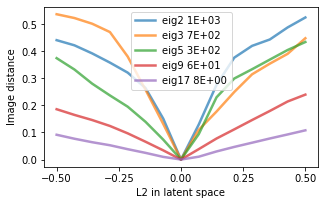

In [6]:
from core.hessian_axis_visualize import vis_eigen_action, vis_eigen_explore, vis_distance_curve
refvect = feat.cpu().numpy()
mtg, codes_all,  = vis_eigen_explore(refvect, evc_FI, eva_FI, G, eiglist=[1,2,4,8, 16], transpose=False,
      maxdist=0.5, scaling=None, rown=7, sphere=False,
      save=False, namestr="demo")
distmat, ticks, fig = vis_distance_curve(refvect, evc_FI, eva_FI, G, ImDist, eiglist=[1,2,4,8,16],
                   maxdist=0.5, rown=5, sphere=False, distrown=15, namestr="demo")

## Spectrum of Hessian
Let's see how fast these eigenvalues decay along the spectrum.

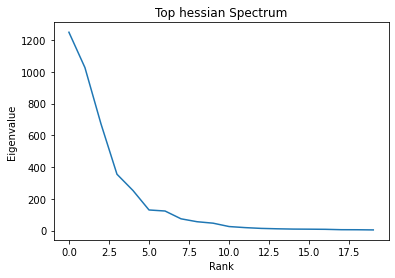

In [7]:
plt.plot(eva_FI[::-1])
plt.title("Top hessian Spectrum")
plt.ylabel("Eigenvalue")
plt.xlabel("Rank")
plt.show()

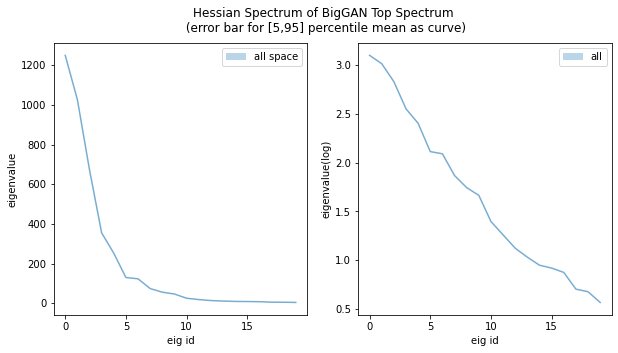

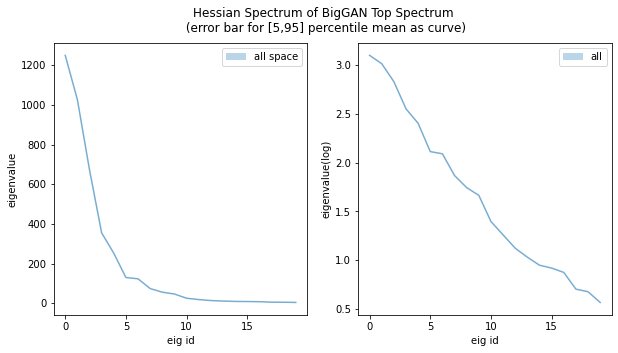

In [8]:
plot_spectra([eva_FI], titstr="BigGAN Top Spectrum", save=False)

Let's compute the full rank Hessian and spectrum, and see its structure. Here the full Hessian is computed by 2nd order backpropagation. It takes ~ 90 sec for full Hessian of BigGAN, on GTX 1060.

In [9]:
eva_BP, evc_BP, H_BP = hessian_compute(G, feat, ImDist, hessian_method="BP") # ~ 91 sec
# Un comment following lines to try other methods and see the speed
# eva_BI_h, evc_BI_h, H_BI_h = hessian_compute(G, feat, ImDist, hessian_method="BackwardIter", cutoff=None)
# eva_FI_h, evc_FI_h, H_FI_h = hessian_compute(G, feat, ImDist, hessian_method="ForwardIter", cutoff=None, EPS=1E-4) # ~ 88 sec

 [================================================================>]  Step: 392ms | Tot: 1m33s | full hessian columns: 255 of 256 256/256 
Hessian computed with BP in 94.50 sec


Correlation similarity of the Full Hessian matrix and the rank 20 approximation: 0.9974


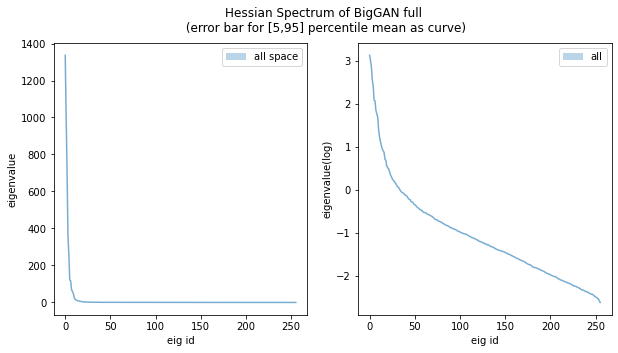

In [10]:
plot_spectra([eva_BP], titstr="BigGAN full", save=False)
cc = np.corrcoef(H_BP.flatten(), H_FI.flatten())[0, 1]
print("Correlation similarity of the Full Hessian matrix and the rank 20 approximation: %.4f"%cc)

We shall see that the full Hessian is quite correlated with the low rank approximation we computed above.
